In [1]:
import sys
sys.path.append("/storage/vbutoi/projects/")
sys.path.append("/storage/vbutoi/libraries/")
from ionpy.analysis import ResultsLoader
import pathlib
import seaborn as sns
import pandas as pd
sns.set_context('talk')
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage',
))

# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE"

In [2]:
path_list = [
    "/storage/vbutoi/scratch/ESE/calibration/09_25_24_ISLES_3D_Subject140Opt_lr1e-4",
    "/storage/vbutoi/scratch/ESE/calibration/09_25_24_ISLES_3D_Subject140Opt_lr1e-5",
    "/storage/vbutoi/scratch/ESE/calibration/09_25_24_ISLES_3D_Subject140Opt_lr1e-6",
    "/storage/vbutoi/scratch/ESE/calibration/09_25_24_ISLES_3D_Subject140Opt_lr1e-7", #lr1e-7
]

df_list_1 = []
for path in path_list:
    try:
        dfc = rs.load_configs(
            path,
            properties=False,
        )
        df = rs.load_metrics(dfc)
        df_list_1.append(df)
    except Exception as e:
        print(e)
df_1 = pd.concat(df_list_1)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
df_1['exp_name'] = 'without image'

In [4]:
path_list_2 = [
    "/storage/vbutoi/scratch/ESE/calibration/09_25_24_ISLES_3D_Subject140Opt_wImage_LRSWEEP", #lr1e-7
]

df_list_2 = []
for path in path_list_2:
    try:
        dfc = rs.load_configs(
            path,
            properties=False,
        )
        df = rs.load_metrics(dfc)
        df_list_2.append(df)
    except Exception as e:
        print(e)
df_2 = pd.concat(df_list_2)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
df_2['exp_name'] = 'with image'

In [6]:
# Concatenate the dfs
df = pd.concat([df_1, df_2])

In [7]:
# for ikey in df.keys():
#     print(ikey)

In [8]:
# def exp_name(path):
#     return str(path).split("/")[-2]

# df.augment(exp_name)

In [9]:
# we need to make batch_size and lr cateogorical variables
df['batch_size'] = df['batch_size'].astype('category')
df['lr'] = df['lr'].astype('category')

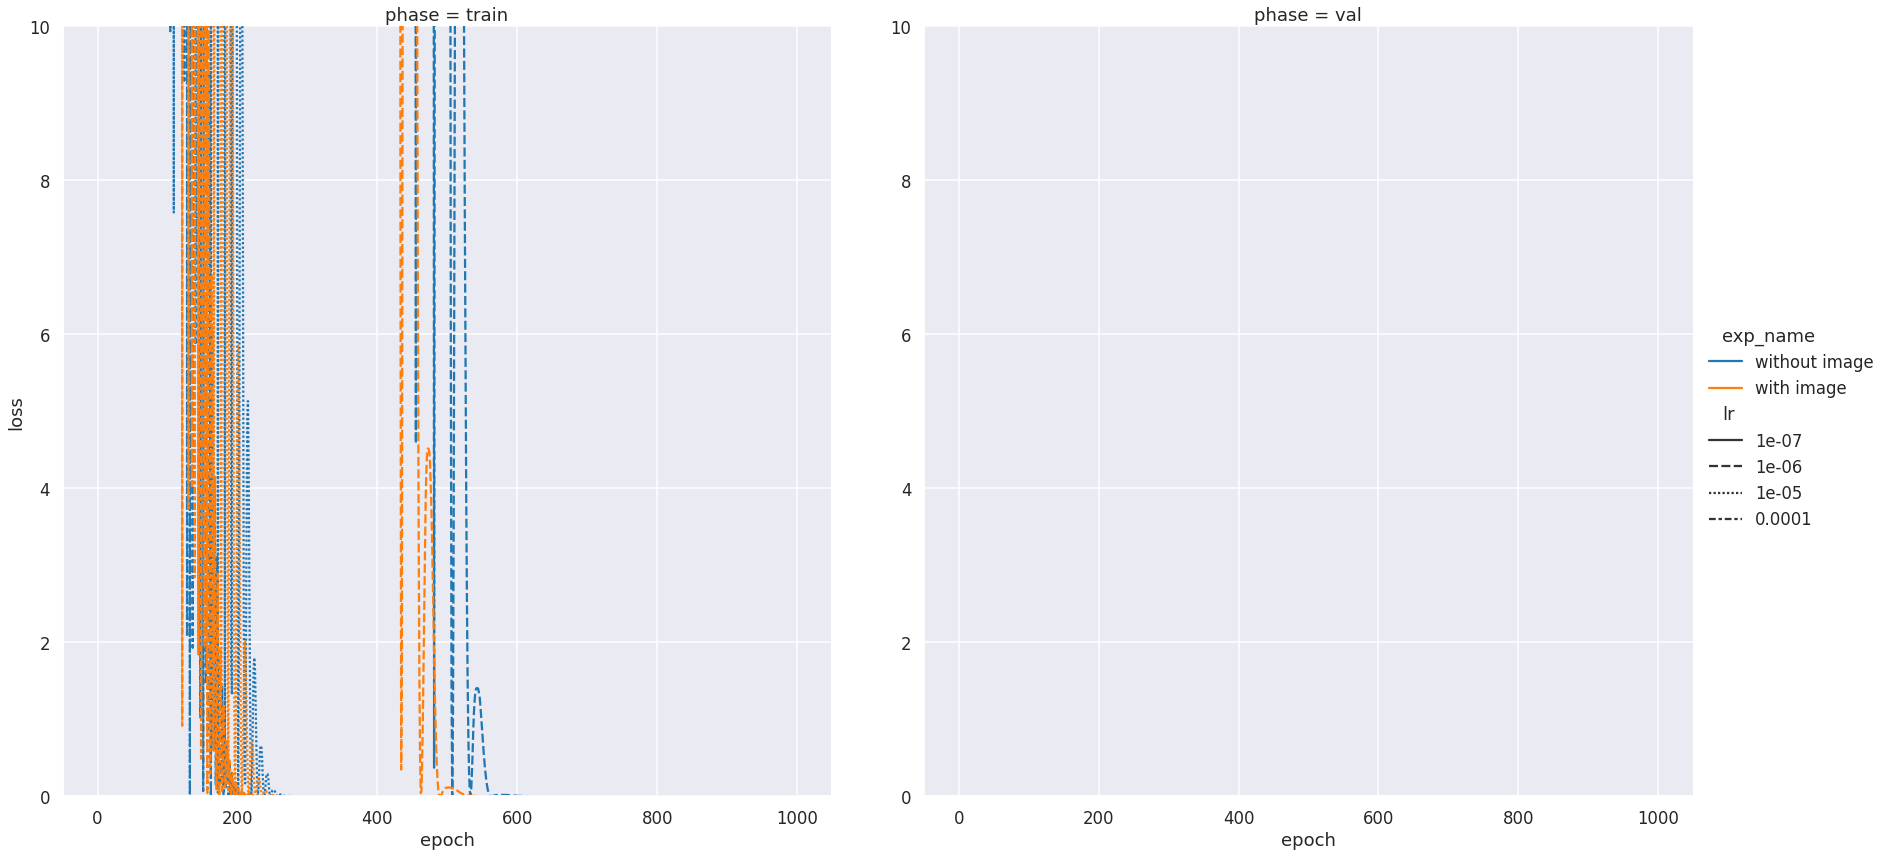

In [10]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='loss',
    hue='exp_name',
    style='lr',
    col='phase',
    kind='line',
    height=12,
    facet_kws=dict(sharey=False),
)

# Set column spacing
g.fig.subplots_adjust(wspace=0.12)
g.set(ylim=(0, 10))

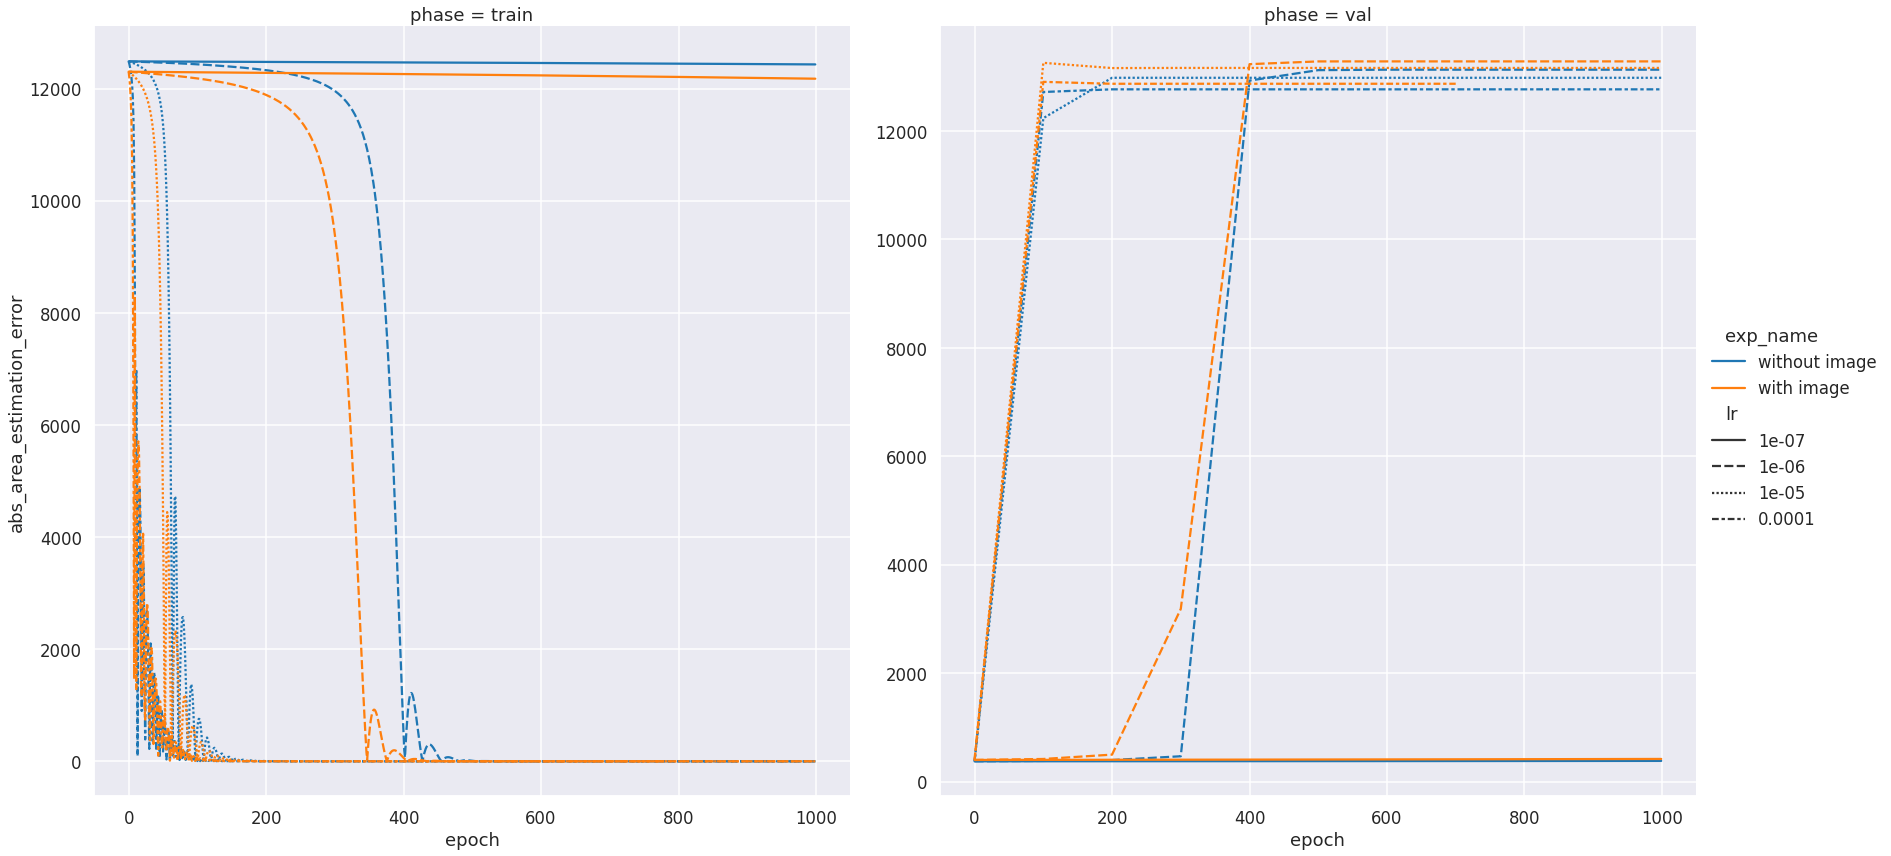

In [11]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='abs_area_estimation_error',
    hue='exp_name',
    style='lr',
    col='phase',
    kind='line',
    height=12,
    facet_kws=dict(sharey=False),
)

# Set column spacig
g.fig.subplots_adjust(wspace=0.12)
# g.set(ylim=(0.0, 0.25))